# **Preprocessing Pipeline**

In [3]:
# Imports
import librosa
import numpy as np
import soundfile as sf
from scipy.signal import fftconvolve

import matplotlib.pyplot as plt

## **1. Synchronization of recorded audio files**

In [5]:
# Load and synchronize audio files
print("Loading Pi1 audio file...")
audio_pi1, sr1 = librosa.load("../Data/raw/pi1_audio.wav", sr=None)
print("Pi1 audio loaded.")

print("Loading Pi2 audio file...")
audio_pi2, sr2 = librosa.load("../Data/raw/pi2_audio.wav", sr=None)
print("Pi2 audio loaded.")

Loading Pi1 audio file...
Pi1 audio loaded.
Loading Pi2 audio file...
Pi2 audio loaded.


In [6]:
# Ensure the sample rates match
if sr1 != sr2:
    raise ValueError("Sample rates of the two files do not match")

# Trim silence
print("Trimming silence from both audio files...")
audio_pi1, _ = librosa.effects.trim(audio_pi1)
audio_pi2, _ = librosa.effects.trim(audio_pi2)

# Cross-correlation using FFT
print("Computing cross-correlation with FFT...")
correlation = fftconvolve(audio_pi1, audio_pi2[::-1], mode='full')
lag = np.argmax(correlation) - len(audio_pi2)
print(f"Detected delay: {lag / sr1} seconds")

# Align the audio files based on the lag
print("Aligning audio files...")
if lag > 0:
    aligned_pi1 = audio_pi1[lag:]
    aligned_pi2 = audio_pi2
else:
    aligned_pi1 = audio_pi1
    aligned_pi2 = audio_pi2[-lag:]

# Ensure both audio files are of the same length
min_length = min(len(aligned_pi1), len(aligned_pi2))
aligned_pi1 = aligned_pi1[:min_length]
aligned_pi2 = aligned_pi2[:min_length]

# Combine both audio files into a stereo format
print("Combining aligned audio into stereo format...")
combined_audio = np.vstack((aligned_pi1, aligned_pi2))

Trimming silence from both audio files...
Computing cross-correlation with FFT...
Detected delay: 11.701065759637189 seconds
Aligning audio files...
Combining aligned audio into stereo format...


In [9]:
# Save the aligned audio files
print("Saving aligned audio files...")
sf.write("../Data/aligned/aligned_pi1.wav", aligned_pi1, sr1)
sf.write("../Data/aligned/aligned_pi2.wav", aligned_pi2, sr1)

# Save a stereo version of the aligned audio
sf.write("../Data/aligned/aligned_stereo.wav", combined_audio.T, sr1)

print("Processing and saving completed.")

Saving aligned audio files...
Processing and saving completed.


## **2. Transformations (STFT & MEL)**

In [12]:
# Paths to your audio files in the Align FFT folder
audio_pi1_path = "../Data/aligned/aligned_pi1.wav"
audio_pi2_path = "../Data/aligned/aligned_pi2.wav"

# Load aligned audio files
print("Loading aligned Pi1 audio file...")
aligned_pi1, sr1 = librosa.load(audio_pi1_path, sr=None)
print("Aligned Pi1 audio loaded.")

print("Loading aligned Pi2 audio file...")
aligned_pi2, sr2 = librosa.load(audio_pi2_path, sr=None)
print("Aligned Pi2 audio loaded.")


Loading aligned Pi1 audio file...
Aligned Pi1 audio loaded.
Loading aligned Pi2 audio file...
Aligned Pi2 audio loaded.


In [13]:
# Apply STFT (Short-term Fourier Transform)
print("Applying Short-term Fourier Transform (STFT)...")
stft_pi1 = librosa.stft(aligned_pi1, n_fft=1024, hop_length=512)
stft_pi2 = librosa.stft(aligned_pi2, n_fft=1024, hop_length=512)

Applying Short-term Fourier Transform (STFT)...


In [14]:
# Convert to Mel-spectrogram
print("Converting to Mel-spectrogram...")
mel_pi1 = librosa.feature.melspectrogram(S=np.abs(stft_pi1), sr=sr1, n_mels=128)
mel_pi2 = librosa.feature.melspectrogram(S=np.abs(stft_pi2), sr=sr2, n_mels=128)

# Convert Mel-spectrogram to dB scale
print("Converting Mel-spectrogram to dB scale...")
mel_db_pi1 = librosa.power_to_db(mel_pi1, ref=np.max)
mel_db_pi2 = librosa.power_to_db(mel_pi2, ref=np.max)

# Normalize the mel-spectrograms
print("Normalizing Mel-spectrograms...")
mel_db_pi1 = (mel_db_pi1 - np.mean(mel_db_pi1)) / np.std(mel_db_pi1)
mel_db_pi2 = (mel_db_pi2 - np.mean(mel_db_pi2)) / np.std(mel_db_pi2)

Converting to Mel-spectrogram...
Converting Mel-spectrogram to dB scale...
Normalizing Mel-spectrograms...


In [15]:
# Save Mel-spectrograms as numpy arrays for future use
print("Saving Mel-spectrograms...")
np.save("mel_db_pi1.npy", mel_db_pi1)
np.save("mel_db_pi2.npy", mel_db_pi2)

Saving Mel-spectrograms...


Plotting and saving Mel-spectrograms...


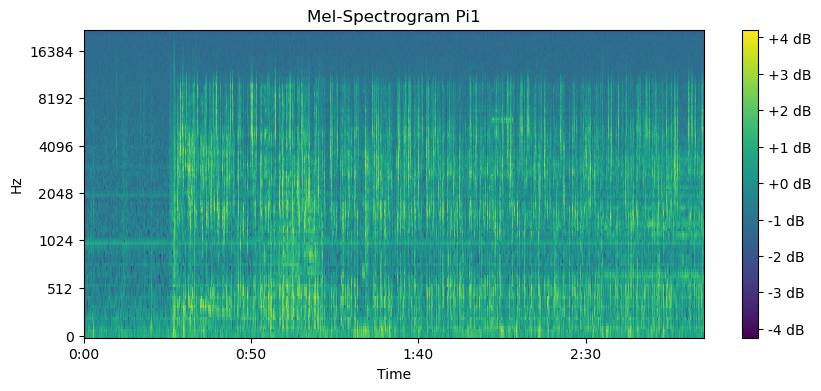

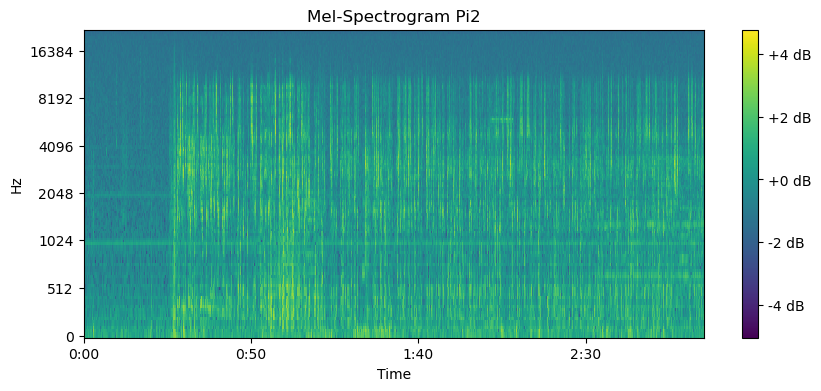

In [17]:
# Plot and save the Mel-spectrograms
print("Plotting and saving Mel-spectrograms...")
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_pi1, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram Pi1')
plt.savefig('../Data/mel/mel_spectrogram_pi1.png')
plt.show()

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_pi2, sr=sr2, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram Pi2')
plt.savefig('../Data/mel/mel_spectrogram_pi2.png')
plt.show()

## **3. Frame Generation**

In [22]:
def generate_frames(mel_spectrogram, frame_size=128, hop_size=64):
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))

    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]
    
    return frames

# Generate frames for Pi1 and Pi2
frames_pi1 = generate_frames(mel_db_pi1)
frames_pi2 = generate_frames(mel_db_pi2)

# You can now use these frames for autoencoder training

## **4. Autoencoder**

## 4.1 Architecture

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape[0] * input_shape[1], 128),
            nn.ReLU(),
            nn.Linear(128, 64),  # Latent space
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_shape[0] * input_shape[1]),
            nn.Sigmoid(),  # Use Sigmoid to ensure values are in the range [0,1]
            nn.Unflatten(1, input_shape)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
input_shape = (frames_pi1.shape[1], frames_pi1.shape[2])  # Shape based on frames
autoencoder = Autoencoder(input_shape)

# Print model architecture
print(autoencoder)

ModuleNotFoundError: No module named 'torch'

## 4.2 Data preparation

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# Convert NumPy arrays to PyTorch tensors
frames_pi1_tensor = torch.Tensor(frames_pi1)
frames_pi2_tensor = torch.Tensor(frames_pi2)

# Create a DataLoader for batch processing
train_dataset = TensorDataset(frames_pi1_tensor, frames_pi1_tensor)  # Inputs and targets are the same
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

## 4.3 AE Training


In [ ]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training the autoencoder
epochs = 50
for epoch in range(epochs):
    autoencoder.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}')

# Save the trained model
torch.save(autoencoder.state_dict(), "autoencoder_model.pth")

## 4.4 AE Evaluation

In [ ]:
autoencoder.eval()  # Set the model to evaluation mode
with torch.no_grad():
    reconstructed_frames = autoencoder(frames_pi1_tensor)
    reconstruction_error = torch.mean(torch.abs(frames_pi1_tensor - reconstructed_frames), dim=[1, 2])

# Convert error to NumPy array for further processing
reconstruction_error = reconstruction_error.numpy()

# Define a threshold for anomaly detection (e.g., 95th percentile)
threshold = np.percentile(reconstruction_error, 95)
print(f"Anomaly detection threshold: {threshold}")

## 4.5 Test AE

In [ ]:
# Test on new data (Pi2)
with torch.no_grad():
    test_reconstructed_frames = autoencoder(frames_pi2_tensor)
    test_reconstruction_error = torch.mean(torch.abs(frames_pi2_tensor - test_reconstructed_frames), dim=[1, 2])

# Convert to NumPy
test_reconstruction_error = test_reconstruction_error.numpy()

# Detect anomalies
anomalies = test_reconstruction_error > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

## 4.6 Save Model and Results

In [ ]:
# Save the trained model
torch.save(autoencoder.state_dict(), 'trained_autoencoder.pth')

# Save reconstruction errors
np.save('reconstruction_errors.npy', reconstruction_error)